In [129]:
import random
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from tqdm import trange

In [130]:
np.random.seed(42)
random.seed(42)

In [131]:
ACTION_TAKE_MORE = 'hit'
ACTION_STOP_TAKING = 'stick'
COLOR_BLACK = 'black'
COLOR_RED = 'red'


@dataclass
class Card:
    number: int
    color: str


def get_new_card():
    number = random.randint(1, 10)

    color = np.random.choice(
        [COLOR_RED, COLOR_BLACK],
        1,
        p=[1/3, 2/3]
    )[0]

    return Card(number, color)

def apply_new_card_to_state(s, card, player):
    taker_sum, player_sum = s
    delta = card.number * \
                (-1 if card.color == COLOR_RED else 1)
    if player:
        return taker_sum, player_sum + delta
    else:
        return taker_sum + delta, player_sum

def calc_reward_on_take_more(s):
    _, player_sum = s

    if player_sum < 0 or player_sum > 21:
        return -1
    else:
        return 0


def take_cards_as_taker(s):
    taker_sum, player_sum = s
    while 0 <= taker_sum < 17:
        new_card = get_new_card()
        taker_sum, _ = apply_new_card_to_state(
            (taker_sum, player_sum),
            new_card,
            False
        )
    return taker_sum, player_sum


def calc_reward_on_stop_taking(s):
    taker_sum, player_sum = s
    if taker_sum < 0 or taker_sum > 21 or taker_sum < player_sum:
        return 1
    elif taker_sum == player_sum:
        return 0
    else:
        return -1


def is_terminal(s):
    taker_sum, player_sum = s
    return taker_sum < 0 \
        or player_sum < 0 \
        or player_sum > 21 \
        or taker_sum >= 17


def environment_step(s, a):
    if a == ACTION_TAKE_MORE:
        new_card = get_new_card()
        new_s = apply_new_card_to_state(s, new_card, True)
        reward = calc_reward_on_take_more(new_s)
        return new_s, reward
    elif a == ACTION_STOP_TAKING:
        new_s = take_cards_as_taker(s)
        reward = calc_reward_on_stop_taking(new_s)
        return new_s, reward

s1, r = environment_step((1, 18), ACTION_TAKE_MORE)
s1, r, is_terminal(s1)

((1, 20), 0, False)

In [132]:
def get_start_state():
    taker_card, player_card = get_new_card(), get_new_card()
    return taker_card.number, player_card.number

def epsilon_greedy(best_action, n, n0, s):
    e = n0 / (n0 + np.sum(n[s]))
    if np.random.random(1)[0] <= e:
        a = random.choice([0, 1])
    else:
        a = best_action
    return a

def glie_mc_estimate(episodes, n0, gamma=1):
    policy = np.zeros((11, 22), dtype=int)
    q = np.zeros((11, 22, 2))
    n = np.zeros((11, 22, 2))

    action_number_to_str = {
        0: ACTION_TAKE_MORE,
        1: ACTION_STOP_TAKING
    }

    for _ in trange(episodes):
        episode = list()
        episode_without_rewards = list()

        s = get_start_state()

        while not is_terminal(s):
            # e = n0 / (n0 + np.sum(n[s]))
            # if np.random.random(1)[0] <= e:
            #     a = random.choice([0, 1])
            # else:
            #     a = policy[s]
            a = epsilon_greedy(policy[s], n, n0, s)
            s1, r = environment_step(
                s,
                action_number_to_str[a]
            )
            episode.append((s, a, r))
            episode_without_rewards.append((s, a))
            s = s1
        # print(episode)
        g = 0
        for i in range(len(episode) - 1, -1, -1):
            s, a, r = episode[i]
            g = gamma * g + r

            if episode_without_rewards.index((s, a)) != i:
                continue

            q_index = s[0], s[1], a
            n[q_index] += 1
            q[q_index] += 1 / n[q_index] * (g - q[q_index])
            a_star = np.argmax(q[s])
            policy[s] = a_star

    return policy, q

policy_mc, q_mc = glie_mc_estimate(10000, 100);

100%|██████████| 10000/10000 [00:01<00:00, 7321.46it/s]


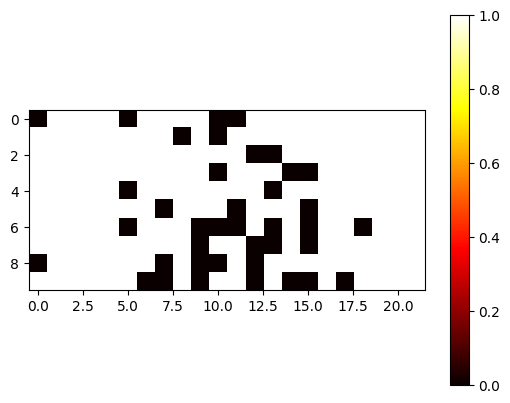

In [133]:
plt.imshow(policy_mc[1:, :], cmap='hot')
plt.colorbar();

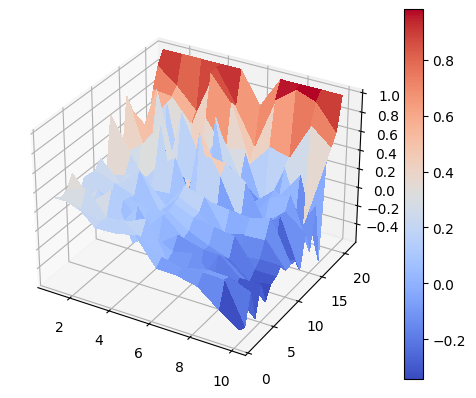

In [134]:
def plot_q(q):
    X = np.arange(1, 11, 1)
    Y = np.arange(1, 22, 1)
    X, Y = np.meshgrid(X, Y)
    Z = np.max(q, axis=2)[X, Y]

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf)

plot_q(q_mc)

In [135]:
def sarsa_estimate(episodes, n0, lambda_coef, gamma, mse_collect=False, q_mc=None):
    q = np.zeros((11, 22, 2))
    e = np.zeros_like(q)
    n = np.zeros_like(q)

    action_number_to_str = {
        0: ACTION_TAKE_MORE,
        1: ACTION_STOP_TAKING
    }
    mse_vals = list()

    for _ in trange(episodes):
        s = get_start_state()
        a = epsilon_greedy(np.argmax(q[s]), n, n0, s)

        while not is_terminal(s):
            s1, r = environment_step(
                s,
                action_number_to_str[a]
            )
            sa_index = s[0], s[1], a
            if not is_terminal(s1):
                a1 = epsilon_greedy(np.argmax(q[s1]), n, n0, s1)
                s1a1_index = s1[0], s1[1], a1
                td_error = r + gamma * q[s1a1_index] - q[sa_index]
            else:
                a1 = None
                td_error = r - q[sa_index]
            e[sa_index] += 1
            n[sa_index] += 1
            alpha = 1 / n[sa_index]
            q += alpha * td_error * e
            e *= gamma * lambda_coef
            s = s1
            a = a1
        if mse_collect:
            mse = np.sum((q - q_mc) ** 2)
            mse_vals.append(mse)
    return q, mse_vals


100%|██████████| 10000/10000 [00:01<00:00, 7418.65it/s]


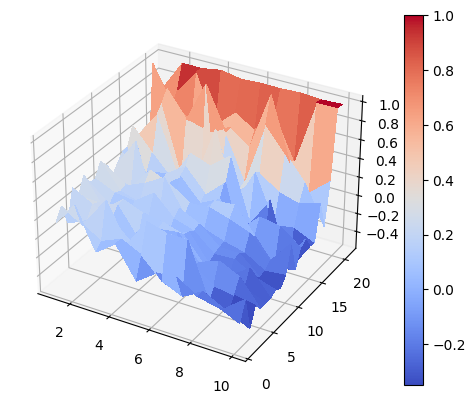

In [136]:
q_sarsa, _ = sarsa_estimate(10000, 100, 0.2, 1)
plot_q(q_sarsa)

100%|██████████| 10000/10000 [00:01<00:00, 6623.32it/s]


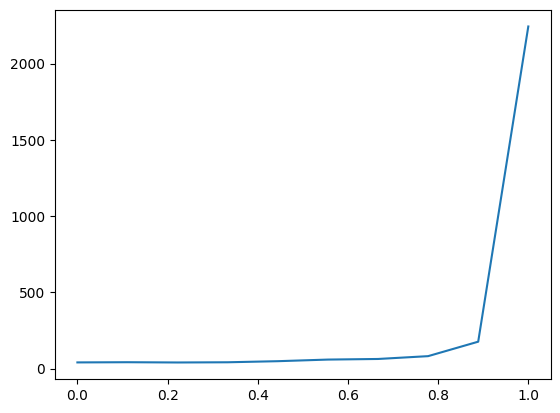

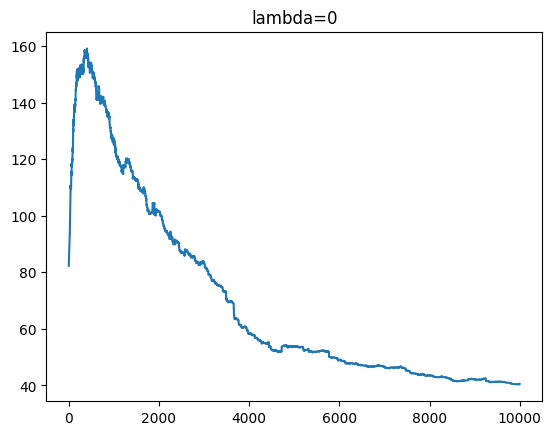

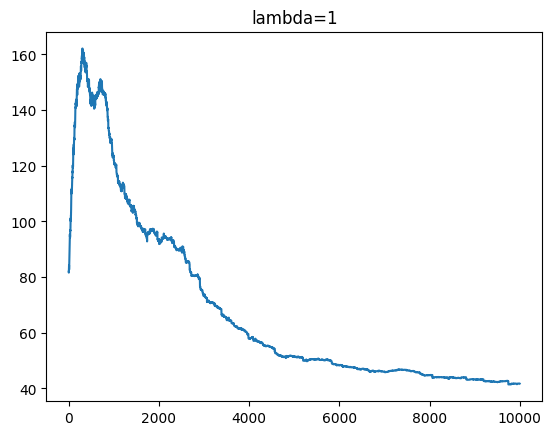

In [137]:
mse_vals = list()
lambdas = np.linspace(0, 1, 10)
mse_during_training_dict = dict()
episodes_count = 10000
for i, lambda_value in enumerate(lambdas):
    q_sarsa_local, mse_during_training = sarsa_estimate(
        episodes_count, 100, lambda_value, 1,
        mse_collect=np.isclose(i, 0) or np.isclose(i, 1),
        q_mc=q_mc
    )
    if mse_during_training:
        mse_during_training_dict[i] = mse_during_training
    mse = np.sum((q_sarsa_local - q_mc) ** 2)
    mse_vals.append(mse)
fig, ax = plt.subplots()
ax.plot(lambdas, mse_vals)
for k, v in mse_during_training_dict.items():
    fig, ax = plt.subplots()
    ax.plot(np.arange(0, episodes_count), v)
    ax.set_title(f'lambda={k}')